## Dependencies

In [1]:
# Dependencies to Visualize the model
%matplotlib inline
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

In [2]:
# Filepaths, pandas, numpy, Tensorflow, and scikit-image
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import skimage as sk


2024-04-12 09:27:47.792366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler

### Keras Specific Dependencies

In [4]:
# Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist

## Loading and Preprocessing our Data

### Load the Skin Cancer Image Dataset and Metadata

Number of images loaded: 10015


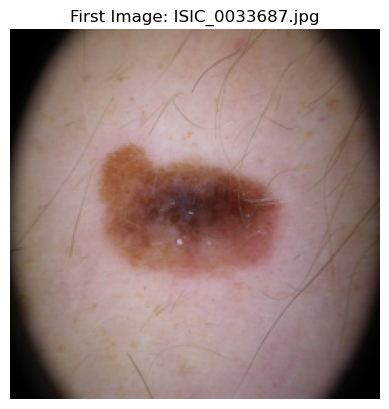

In [5]:
from PIL import Image

# Define folder path where images are stored
folder_path = "Resources/Skin Cancer/Split"

# Load images
def load_images_from_folder(folder_path, image_size=(224, 224)):
    """
    Load images from all subfolders of a given folder and resize them to a specified size.
    
    Args:
    - folder_path (str): The path to the folder containing the subfolders.
    - image_size (tuple, optional): The desired size of the images. Defaults to (224, 224).

    
    Returns:
    - images (list): A list of tuples, where each tuple contains a filename and its corresponding, resized image.
    """
    images = []
    # Iterate over all subfolders and their contents
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg"):
                file_path = os.path.join(root, file)
                img = Image.open(file_path)
                if img is not None:
                    img = img.resize(image_size)
                    images.append((file, img))  # Storing filename along with the image
    return images

# Call function to define images
images = load_images_from_folder(folder_path)

# Check that all 10,015 images were loaded
print("Number of images loaded:", len(images))

# Check first image
if images:
    # Extract the first image from the list
    first_filename, first_image = images[0]
    
    # Display the first image
    plt.imshow(first_image)
    plt.title("First Image: " + first_filename)  # Add title with filename
    plt.axis('off')  # Turn off axis
    plt.show()

In [6]:
# Define csv file name
csv_file = "Resources/HAM10000_metadata.csv"

# Load metadata csv
def load_metadata_from_csv(csv_file):
    """
    Load metadata from a CSV file and return it as a DataFrame.
    
    Args:
    - csv_file (str): The path to the CSV file containing the metadata.
    
    Returns:
    - metadata (DataFrame): A DataFrame containing the metadata read from the CSV file.
    """
    metadata = pd.read_csv(csv_file)
    return metadata

# Call function to define metadata
metadata = load_metadata_from_csv(csv_file)

# Preview pandas dataframe to confirm metadata loaded correctly
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
# Match images with metadata based on filenames
def match_images_with_metadata(images, metadata):
    """
    Match images with metadata based on filenames.

    Args:
    - images (list): A list of tuples containing (filename, image).
    - metadata (DataFrame): A DataFrame containing metadata.

    Returns:
    - matched_data (list): A list of tuples containing (filename, image, matched metadata row).
    """
    matched_data = []
    for filename, img in images:
        # Extract the filename without extension
        filename_without_ext = os.path.splitext(filename)[0]
        # Find corresponding row in metadata with matching filename
        matched_row = metadata.loc[metadata['image_id'] == filename_without_ext]
        # If a match is found, store the image and metadata together
        if not matched_row.empty:
            matched_data.append((filename, img, matched_row))
    return matched_data

# Call function to define matched_data
matched_data = match_images_with_metadata(images, metadata)

# Check that all 10,015 images were matched with metadata
print("Number of matched images and metadata:", len(matched_data))

Number of matched images and metadata: 10015


In [8]:
# Create pandas dataframe of metadata matched with corresponding image
def create_metadata_image_dataframe(matched_data):
    """
    Create a DataFrame containing metadata with corresponding images.
    
    Args:
    - matched_data (list): A list of tuples containing (filename, image, metadata_row).
    
    Returns:
    - df (DataFrame): A DataFrame where each row corresponds to a matched image and its metadata.
    """
    data = []
    for filename, img, metadata_row in matched_data:
        metadata_dict = metadata_row.to_dict(orient='records')[0]  # Convert metadata row to dictionary
        metadata_dict['Image'] = img  # Add the image to the metadata dictionary
        data.append(metadata_dict)
    df = pd.DataFrame(data)
    return df

# Call function to define metadata_image_df
metadata_image_df = create_metadata_image_dataframe(matched_data)

# Preview dataframe
metadata_image_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0007117,ISIC_0033687,mel,histo,35.0,male,back,<PIL.Image.Image image mode=RGB size=224x224 a...
1,HAM_0003352,ISIC_0032599,nv,histo,35.0,unknown,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...
2,HAM_0000417,ISIC_0025783,mel,histo,65.0,male,back,<PIL.Image.Image image mode=RGB size=224x224 a...
3,HAM_0004224,ISIC_0027194,bkl,confocal,80.0,male,face,<PIL.Image.Image image mode=RGB size=224x224 a...
4,HAM_0005067,ISIC_0026261,nv,follow_up,50.0,female,upper extremity,<PIL.Image.Image image mode=RGB size=224x224 a...


In [9]:
# Get unique class labels from the 'dx' column
class_names = list(metadata_image_df['dx'].unique())

print("Class Names:", class_names)

Class Names: ['mel', 'nv', 'bkl', 'bcc', 'akiec', 'vasc', 'df']


## Image Color Analysis

### HSV Color Analysis

In [34]:
from skimage import color

def calculate_hsv_histogram(image):
    """
    Calculate HSV histograms for an image.

    Parameters:
    - image: PIL.Image.Image object representing the input image.

    Returns:
    - hsv_histogram: NumPy array containing the flattened concatenated histograms of hue, saturation, and value.
    """
    # Convert PIL Image to NumPy array
    image_array = np.array(image)

    # Define number of bins
    num_bins = 256 

    # Convert the image to HSV color space
    hsv_image = color.rgb2hsv(image_array)

    # Calculate histograms for each component (Hue, Saturation, Value)
    hue_histogram, _ = np.histogram(hsv_image[:,:,0], bins=num_bins, range=(0, 1))
    saturation_histogram, _ = np.histogram(hsv_image[:,:,1], bins=num_bins, range=(0, 1))
    value_histogram, _ = np.histogram(hsv_image[:,:,2], bins=num_bins, range=(0, 1))

    # Concatenate and flatten the histograms
    hsv_histogram = np.concatenate((hue_histogram, saturation_histogram, value_histogram)).flatten()

    return hsv_histogram

# Create a new DataFrame based on metadata_image_df
hsv_metadata_image_df = metadata_image_df.copy()

# Calculate HSV histograms and assign them to the new DataFrame
hsv_metadata_image_df['hsv_histogram'] = hsv_metadata_image_df['Image'].apply(calculate_hsv_histogram)

# Display the updated DataFrame
hsv_metadata_image_df.head()



,lesion_id,image_id,dx,dx_type,age,sex,localization,Image,hsv_histogram
0,HAM_0007117,ISIC_0033687,mel,histo,35.0,male,back,<PIL.Image.Image image mode=RGB size=224x224 a...,"[3510, 1909, 1362, 1768, 1796, 1803, 1828, 186..."
1,HAM_0003352,ISIC_0032599,nv,histo,35.0,unknown,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...,"[2499, 1829, 1507, 1027, 859, 759, 533, 379, 2..."
2,HAM_0000417,ISIC_0025783,mel,histo,65.0,male,back,<PIL.Image.Image image mode=RGB size=224x224 a...,"[776, 467, 378, 198, 111, 41, 8, 2, 0, 0, 0, 0..."
3,HAM_0004224,ISIC_0027194,bkl,confocal,80.0,male,face,<PIL.Image.Image image mode=RGB size=224x224 a...,"[2016, 1050, 1245, 1144, 1046, 957, 744, 729, ..."
4,HAM_0005067,ISIC_0026261,nv,follow_up,50.0,female,upper extremity,<PIL.Image.Image image mode=RGB size=224x224 a...,"[4673, 6119, 9063, 12102, 7818, 4736, 2210, 54..."


### RGB Color Analysis

In [35]:
def calculate_rgb_histogram(image):
    """
    Calculate RGB histograms for an image.

    Parameters:
    - image: PIL.Image.Image object representing the input image.

    Returns:
    - rgb_histogram: NumPy array containing the flattened concatenated histograms of red, green, and blue channels.
    """
    # Convert PIL Image to NumPy array
    image_array = np.array(image)

    # Define number of bins
    num_bins = 256

    # Calculate histograms for each RGB channel
    red_histogram, _ = np.histogram(image_array[:,:,0], bins=num_bins, range=(0, 255))
    green_histogram, _ = np.histogram(image_array[:,:,1], bins=num_bins, range=(0, 255))
    blue_histogram, _ = np.histogram(image_array[:,:,2], bins=num_bins, range=(0, 255))

    # Concatenate and flatten the histograms
    rgb_histogram = np.concatenate((red_histogram, green_histogram, blue_histogram)).flatten()

    return rgb_histogram

# Create a new DataFrame based on metadata_image_df
rgb_metadata_image_df = metadata_image_df.copy()

# Calculate RGB histograms and assign them to the new DataFrame
rgb_metadata_image_df['rgb_histogram'] = rgb_metadata_image_df['Image'].apply(calculate_rgb_histogram)

# Display the updated DataFrame
rgb_metadata_image_df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,Image,rgb_histogram
0,HAM_0007117,ISIC_0033687,mel,histo,35.0,male,back,<PIL.Image.Image image mode=RGB size=224x224 a...,"[820, 403, 230, 308, 194, 153, 158, 112, 89, 9..."
1,HAM_0003352,ISIC_0032599,nv,histo,35.0,unknown,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,HAM_0000417,ISIC_0025783,mel,histo,65.0,male,back,<PIL.Image.Image image mode=RGB size=224x224 a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,HAM_0004224,ISIC_0027194,bkl,confocal,80.0,male,face,<PIL.Image.Image image mode=RGB size=224x224 a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,HAM_0005067,ISIC_0026261,nv,follow_up,50.0,female,upper extremity,<PIL.Image.Image image mode=RGB size=224x224 a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Building our Model - Black & White Images

We are going to build a Convolution Neural Network with just the black and white image characteristics.

In [12]:
#Run through classifiers for black and white before moving to color
#Once we get to the point where we are tuning, loot at the differnet filters for convolutional neural networks
#Play with the different steps sizes
#Play around with pooling stages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [13]:
# Preprocess the image data
X = np.array([np.array(img) for _, img, _ in matched_data])
X = X / 255.0  # Normalize pixel values to [0, 1]
y = pd.get_dummies(metadata_image_df['dx'], dtype=int).values  # One-hot encode the target labels
print(X)
print(y)

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Define the CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

In [19]:
# Define custom precision metric function
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [20]:
# Define custom recall metric function
def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

### Compile and Train our Model

Now that we have our model architecture defined, we must compile the model using a loss function and optimizer. We can also specify additional training metrics such as accuracy, precision, and recall

In [21]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])


In [22]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
251/251 [==============================] - 308s 1s/step - loss: 0.9994 - accuracy: 0.6692 - precision: 0.7899 - recall: 0.5384 - val_loss: 0.8700 - val_accuracy: 0.6780 - val_precision: 0.8298 - val_recall: 0.5518
Epoch 2/10
251/251 [==============================] - 277s 1s/step - loss: 0.8319 - accuracy: 0.6922 - precision: 0.8162 - recall: 0.5843 - val_loss: 0.8490 - val_accuracy: 0.6860 - val_precision: 0.8229 - val_recall: 0.5062
Epoch 3/10
251/251 [==============================] - 262s 1s/step - loss: 0.7603 - accuracy: 0.7169 - precision: 0.8194 - recall: 0.6135 - val_loss: 0.7776 - val_accuracy: 0.7174 - val_precision: 0.8019 - val_recall: 0.6550
Epoch 4/10
251/251 [==============================] - 263s 1s/step - loss: 0.7020 - accuracy: 0.7336 - precision: 0.8153 - recall: 0.6477 - val_loss: 0.7851 - val_accuracy: 0.7124 - val_precision: 0.8089 - val_recall: 0.6279
Epoch 5/10
251/251 [==============================] - 285s 1s/step - loss: 0.6593 - accuracy: 0.7540

In [23]:
# Evaluate the model
loss, accuracy, precision, recall = model.evaluate(X_val, y_val)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)

63/63 [==============================] - 20s 302ms/step - loss: 0.9971 - accuracy: 0.7244 - precision: 0.7656 - recall: 0.6945
Validation Loss: 0.9971463680267334
Validation Accuracy: 0.7244133949279785
Validation Precision: 0.7656400203704834
Validation Recall: 0.6945489048957825


In [24]:
from sklearn.metrics import classification_report

# Predict classes for validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_val to class labels
y_val_classes = np.argmax(y_val, axis=1)

# Generate classification report
print(classification_report(y_val_classes, y_pred_classes, target_names=class_names))

63/63 [==============================] - 21s 314ms/step
              precision    recall  f1-score   support

         mel       0.35      0.43      0.39        58
          nv       0.51      0.28      0.36       113
         bkl       0.39      0.42      0.40       208
         bcc       0.62      0.14      0.23        36
       akiec       0.45      0.47      0.46       223
        vasc       0.85      0.88      0.87      1332
          df       0.83      0.73      0.77        33

    accuracy                           0.72      2003
   macro avg       0.57      0.48      0.50      2003
weighted avg       0.72      0.72      0.72      2003



## Building our Model - Color Images

We are going to build another Convolution Neural Network using the Image along with the HSV and RBG color analysis performed previously.

In [43]:
# Prepare the histogram data
rgb_histograms = np.array(rgb_metadata_image_df[['rgb_histogram']].values.tolist())
hsv_histograms = np.array(hsv_metadata_image_df[['hsv_histogram']].values.tolist())
# X_hist = np.concatenate((rgb_histograms, hsv_histograms), axis=1)

In [44]:
# Normalize the histogram data
rgb_histograms = rgb_histograms / rgb_histograms.max(axis=1, keepdims=True)
hsv_histograms = hsv_histograms / hsv_histograms.max(axis=1, keepdims=True)

/var/folders/q4/pxfstmr91k3f4ljkh171th7m0000gp/T/ipykernel_66144/352968877.py:2: RuntimeWarning: invalid value encountered in divide
  rgb_histograms = rgb_histograms / rgb_histograms.max(axis=1, keepdims=True)
/var/folders/q4/pxfstmr91k3f4ljkh171th7m0000gp/T/ipykernel_66144/352968877.py:3: RuntimeWarning: invalid value encountered in divide
  hsv_histograms = hsv_histograms / hsv_histograms.max(axis=1, keepdims=True)


In [45]:
# Step 6: Prepare Target Labels
# One-hot encode the target labels
y = pd.get_dummies(metadata_image_df['dx'],dtype=int).values

In [49]:
# Step 7: Train/Test Split
from sklearn.model_selection import train_test_split

# Splitting histogram data
X_hist_train, X_hist_val, y_train, y_val = train_test_split(
    np.concatenate((rgb_histograms, hsv_histograms), axis=1),
    y, test_size=0.2, random_state=42)

# Splitting image data
X_img_train, X_img_val, _, _ = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Check the shapes
print("Histogram Data Shapes:", X_hist_train.shape, X_hist_val.shape)
print("Image Data Shapes:", X_img_train.shape, X_img_val.shape)


Histogram Data Shapes: (8012, 2, 768) (2003, 2, 768)
Image Data Shapes: (8012, 224, 224, 3) (2003, 224, 224, 3)


In [57]:
# Step 8: Define the Model
from keras.models import Model
from keras.layers import Input, Dense, concatenate

model = Sequential()

# Define image shape
image_shape = (224,224,3)
# Add batch dimension
image_shape_with_batch = (None,) + image_shape

# Define input layers
input_hist_rgb = Input(shape=(rgb_histograms.shape[1],), name='input_hist_rgb')
input_hist_hsv = Input(shape=(hsv_histograms.shape[1],), name='input_hist_hsv')
input_img = Input(shape=(image_shape), name='input_img')

In [58]:
# Concatenate histogram inputs
hist_concat = concatenate([input_hist_rgb, input_hist_hsv])

In [59]:
# Define layers for histogram data
dense_hist_rgb = Dense(128, activation='relu')(input_hist_rgb)
dense_hist_hsv = Dense(128, activation='relu')(input_hist_hsv)

In [61]:
# Define layers for image data
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=image_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [65]:
from keras.layers import Reshape, Flatten

# Flatten the histogram data
hist_flat = Flatten()(hist_concat)

# Concatenate all input layers
concatenated = concatenate([hist_concat, input_img])

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 2), (None, 224, 224, 3)]

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from keras.models import Model

# Define input layers for image data and histogram data
image_input = Input(shape=(224, 224, 3))
rgb_histogram_input = Input(shape=(256,))
hsv_histogram_input = Input(shape=(256,))

In [37]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the histogram data
scaler = MinMaxScaler()
X_train_rgb_hist_normalized = scaler.fit_transform(X_train_rgb_hist)
X_val_rgb_hist_normalized = scaler.transform(X_val_rgb_hist)

X_train_hsv_hist_normalized = scaler.fit_transform(X_train_hsv_hist)
X_val_hsv_hist_normalized = scaler.transform(X_val_hsv_hist)

[[[0.23361823 0.21110529 0.16886931 ...        nan        nan        nan]
  [1.         1.         1.         ...        nan        nan        nan]]]


/var/folders/q4/pxfstmr91k3f4ljkh171th7m0000gp/T/ipykernel_66144/2022644294.py:2: RuntimeWarning: invalid value encountered in divide
  X_hist = X_hist / X_hist.max(axis=1, keepdims=True)


In [38]:
# Prepare the target labels
y = pd.get_dummies(metadata_image_df['dx'], dtype=int).values
print(y[:1])

[[0 0 0 0 1 0 0]]


In [39]:
# Split the data into training and validation sets
X_train_hist, X_val_hist, y_train, y_val = train_test_split(X_hist, y, test_size=0.2, random_state=42)

In [40]:
# Define the CNN architecture
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_hist.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

In [41]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

In [42]:
# Train the model
history = model.fit(X_train_hist, y_train, epochs=10, batch_size=32, validation_data=(X_val_hist, y_val))

Epoch 1/10


ValueError: in user code:

    File "/Users/amandaderdiger/anaconda3/envs/nn/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/amandaderdiger/anaconda3/envs/nn/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/amandaderdiger/anaconda3/envs/nn/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/amandaderdiger/anaconda3/envs/nn/lib/python3.8/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Users/amandaderdiger/anaconda3/envs/nn/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/amandaderdiger/anaconda3/envs/nn/lib/python3.8/site-packages/keras/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_1' (type Sequential).
    
    Input 0 of layer "dense_2" is incompatible with the layer: expected axis -1 of input shape to have value 2, but received input with shape (None, 2, 768)
    
    Call arguments received by layer 'sequential_1' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 2, 768), dtype=float32)
      • training=True
      • mask=None


In [27]:
# Evaluate the model
loss, accuracy, precision, recall = model.evaluate(X_val, y_val)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (10015, 3) + inhomogeneous part.

In [ ]:
# Predict classes for validation data
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_val to class labels
y_val_classes = np.argmax(y_val, axis=1)

# Generate classification report
print(classification_report(y_val_classes, y_pred_classes, target_names=class_names))